# TVA sur les biens alimentaires

In [1]:
%matplotlib inline

from __future__ import division

import numpy as np
import os
import pandas as pd
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns

from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.build_survey_data.calibration_aliss import get_adjusted_input_data_frame

pd.set_option('precision', 3)

In [2]:
def build_scenarios(reform_key = 'aliss_sante'):
    year = 2014
    data_year = 2011
    scenario_kwargs = dict(year = year, data_year = 2011, reform_key = reform_key)
    survey_scenario = SurveyScenario.create(**scenario_kwargs)
    #
    adjusted_scenario_kwargs = dict(scenario_kwargs)
    adjusted_scenario_kwargs.update(dict(
        data_year = None,
        input_data_frame = get_adjusted_input_data_frame(reform_key = reform_key[6:])
        ))
    adjusted_survey_scenario = SurveyScenario.create(**adjusted_scenario_kwargs)
    return survey_scenario, adjusted_survey_scenario

('kantar_expenditures_total:', 52.035641343999998)
('bdf_expenditures_total: ', 52.218515455999999)
('population_kantar_total: ', 11968.229858398438)
('bdf_expenditures_total: ', 126.62905879583185)

/home/benjello/openfisca/openfisca-france-indirect-taxation/openfisca_france_indirect_taxation/build_survey_data/calibration_aliss.py:118: FutureWarning: eval expressions containing an assignment currentlydefault to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  input_data_frame.eval("age = 0 + (agepr > 30) + (agepr > 45) + (agepr > 60)",
/home/benjello/openfisca/openfisca-survey-manager/openfisca_survey_manager/statshelpers.py:122: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  ret[and_(data >= lower, data < upper)] = labels[i]
/home/benjello/openfisca/openfisca-france-indirect-taxation/openfisca_france_indirect_taxation/build_survey_data/calibration_aliss.py:506: FutureWarning: eval expressions containing an assignment currentlydefault to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  'adjusted_bdf_budget_share = kan

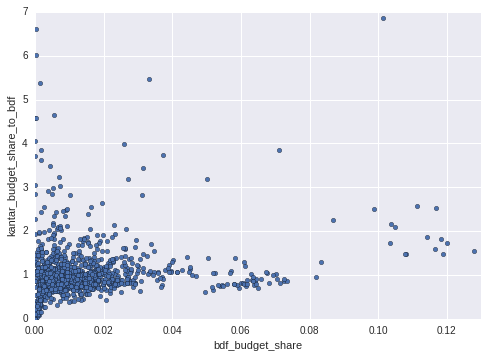

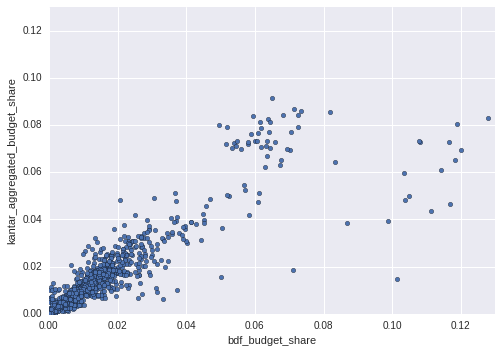

In [3]:
survey_scenario, adjusted_survey_scenario = build_scenarios()

In [4]:
alimentation_domicile_hors_alcool = [
    "depenses_ht_{}".format(key) for key in survey_scenario.tax_benefit_system.column_by_name.keys() \
    if key.startswith(u'poste_01')
    ]
alimentation_domicile = alimentation_domicile_hors_alcool + [
    'depenses_biere',
    'depenses_vin',
    'depenses_alcools_forts'
    ]
depenses_ht_tvas = [
    "depenses_ht_{}".format(key) for key in survey_scenario.tax_benefit_system.column_by_name.keys() \
    if key.startswith(u'tva_taux_')
    ]
tvas = [
    key for key in survey_scenario.tax_benefit_system.column_by_name.keys() \
    if key.startswith(u'tva_taux_')
    ] + ['tva_total']
variables = alimentation_domicile + [
    'poste_agrege_01',
    'poste_agrege_02', 
    ] + depenses_ht_tvas + tvas

In [7]:
def build_pivot_table(variables, by = 'niveau_vie_decile'):
    pivot_table = pd.DataFrame()
    reference_pivot_table = pd.DataFrame()
    adjusted_pivot_table = pd.DataFrame()
    for variable in variables:
        pivot_table = pd.concat([
            pivot_table,
            survey_scenario.compute_pivot_table(values = [variable], columns = [by])
            ])
        reference_pivot_table = pd.concat([
            reference_pivot_table.fillna(0),
            survey_scenario.compute_pivot_table(values = [variable], columns = [by],
                                               reference = True)
            ])
        adjusted_pivot_table = pd.concat([
            adjusted_pivot_table,
            adjusted_survey_scenario.compute_pivot_table(values = [variable], columns = [by])
            ])
    return pd.concat({
        'reform': pivot_table,
        'reference': reference_pivot_table,
        'adjusted': adjusted_pivot_table,
        'reform-reference': pivot_table - reference_pivot_table,
        'adjusted-reform': adjusted_pivot_table - pivot_table,
        'adjusted-reference': adjusted_pivot_table - reference_pivot_table,
        })

def build_aggreggates(variables, by = 'niveau_vie_decile'):
    aggregates = dict()
    reference_aggregates = dict()
    adjusted_aggregates = dict()
    for variable in variables:
        aggregates[variable] = survey_scenario.compute_aggregate(variable) / 1e9
        reference_aggregates[variable] = (
            survey_scenario.compute_aggregate(variable, reference = True) / 1e9
            if np.isfinite(survey_scenario.compute_aggregate(variable, reference = True)) else 0
            )
        adjusted_aggregates[variable] = adjusted_survey_scenario.compute_aggregate(variable) / 1e9
    return pd.DataFrame(dict(
        reform = aggregates,
        reference = reference_aggregates,
        adjusted = adjusted_aggregates,
        ))


In [8]:
aggregates = build_aggreggates(variables)
pivot_table = build_pivot_table(variables)

In [9]:
assert (pd.DataFrame(
    aggregates.loc[aliment, 'reform'] - aggregates.loc[aliment, 'reform'] for aliment in alimentation_domicile
    ) == 0).all().all()

In [10]:
assert aggregates.loc['poste_agrege_02', 'reform'] - aggregates.loc['poste_agrege_02', 'reference'] < 1e-7

In [11]:
aggregates['reform - reference'] = aggregates.reform - aggregates.reference
aggregates['adjusted - reform'] = aggregates.adjusted - aggregates.reform
aggregates['adjusted - reference'] = aggregates.adjusted - aggregates.reference
aggregates.loc[
    [index for index in aggregates.index if index.startswith('tva_') or index.startswith('poste_agrege')]
    ]

,adjusted,reference,reform,reform - reference,adjusted - reform,adjusted - reference
poste_agrege_01,126.749,124.140,131.441,7.301e+00,-4.692e+00,2.609
poste_agrege_02,22.552,22.431,22.431,2.735e-08,1.205e-01,0.120
tva_taux_01_1_1_1_1,2.115,0.000,2.264,2.264e+00,-1.495e-01,2.115
tva_taux_01_1_1_3_3,0.408,0.000,0.427,4.273e-01,-1.912e-02,0.408
tva_taux_01_1_1_4_1,0.198,0.000,0.214,2.139e-01,-1.560e-02,0.198
tva_taux_01_1_1_4_2,0.146,0.000,0.151,1.508e-01,-5.241e-03,0.146
tva_taux_01_1_1_4_3,0.072,0.000,0.081,8.129e-02,-9.457e-03,0.072
tva_taux_01_1_4_1_1_c,0.015,0.000,0.019,1.938e-02,-4.079e-03,0.015
tva_taux_01_1_4_2_1,0.301,0.000,0.300,2.997e-01,1.254e-03,0.301
tva_taux_01_1_4_2_2,0.364,0.000,0.400,4.003e-01,-3.672e-02,0.364


In [12]:
from openfisca_france_indirect_taxation.model.consommation.postes_coicop import get_legislation_data_frames
categories_fiscales_data_frame, codes_coicop_data_frame = get_legislation_data_frames()

In [14]:
df = pivot_table.reset_index().rename(columns = {u'level_0': 'simulation', u'level_1': 'variable'})

In [16]:
df

niveau_vie_decile,simulation,variable,1,2,3,4,5,6,7,8,9,10
0,adjusted,depenses_ht_poste_01_1_1_1_1,331.511,369.209,399.858,428.035,440.682,467.610,484.495,502.846,519.513,553.169
1,adjusted,depenses_ht_poste_01_1_1_3_3,90.494,107.714,109.792,143.789,114.933,136.045,140.167,135.485,147.626,156.385
2,adjusted,depenses_ht_poste_01_1_1_4_1,42.851,41.582,42.559,44.032,44.269,55.330,54.898,55.455,54.942,60.560
3,adjusted,depenses_ht_poste_01_1_1_4_2,44.350,46.012,44.508,60.586,52.706,58.367,62.095,58.434,66.034,68.175
4,adjusted,depenses_ht_poste_01_1_1_4_3,20.279,19.189,29.895,30.357,28.020,31.799,21.986,27.463,31.236,30.564
5,adjusted,depenses_ht_poste_01_1_2_1_1,167.566,176.387,197.678,220.613,253.082,279.734,268.050,285.152,336.629,359.257
6,adjusted,depenses_ht_poste_01_1_2_3_1,28.397,44.708,31.279,29.482,26.930,25.655,36.688,51.309,36.354,74.331
7,adjusted,depenses_ht_poste_01_1_2_4_1,48.117,58.940,68.475,70.694,76.807,87.414,81.096,96.051,98.895,91.770
8,adjusted,depenses_ht_poste_01_1_2_4_2,183.039,214.183,253.172,284.926,316.256,313.273,307.563,326.523,344.761,363.605
9,adjusted,depenses_ht_poste_01_1_2_5_1,108.880,137.512,149.797,150.349,142.044,171.419,170.866,187.852,187.340,221.550


In [ ]:
df

In [ ]:
data = (adjusted_pivot_table - pivot_table).loc[['poste_agrege_01', 'poste_agrege_02', 'tva_total']].T

In [ ]:
data

In [ ]:
data.plot()
sns.despine()

In [ ]:
sns.plot.show()